## Homework

---

### Q1

Convert your **Gibbs sampler** from the previous homework to be a **Metropolis within Gibbs** sampler. 
- Do not derive any full conditionals and instead just use the joint distribution which is the product of the likelihood with the priors 
    - Note that in fact you must only be proportional to the joint since irrelevant priors of "the other parameter" will cancel in the ratio
- Note that $\tau$ must be positive so proposals $\tilde \tau$ must also be positive. The easiest way to achieve this would be to use independent samples (that do not depend on $\tau^{(t-1)}$ from exponential, half normal, gamma, or inverse gamma distributions (and other distributions defining strictly positive random variables).
- When considering using independent proposal distributions one option of some note is to use the prior $p(\tau)$ as this proposal distribution

*Clearly articulate your specification and provide a demonstration showing the Bayesian inference it provides, in contrast to that of your previous Gibbs sampler (of Q2 from the last homework).*

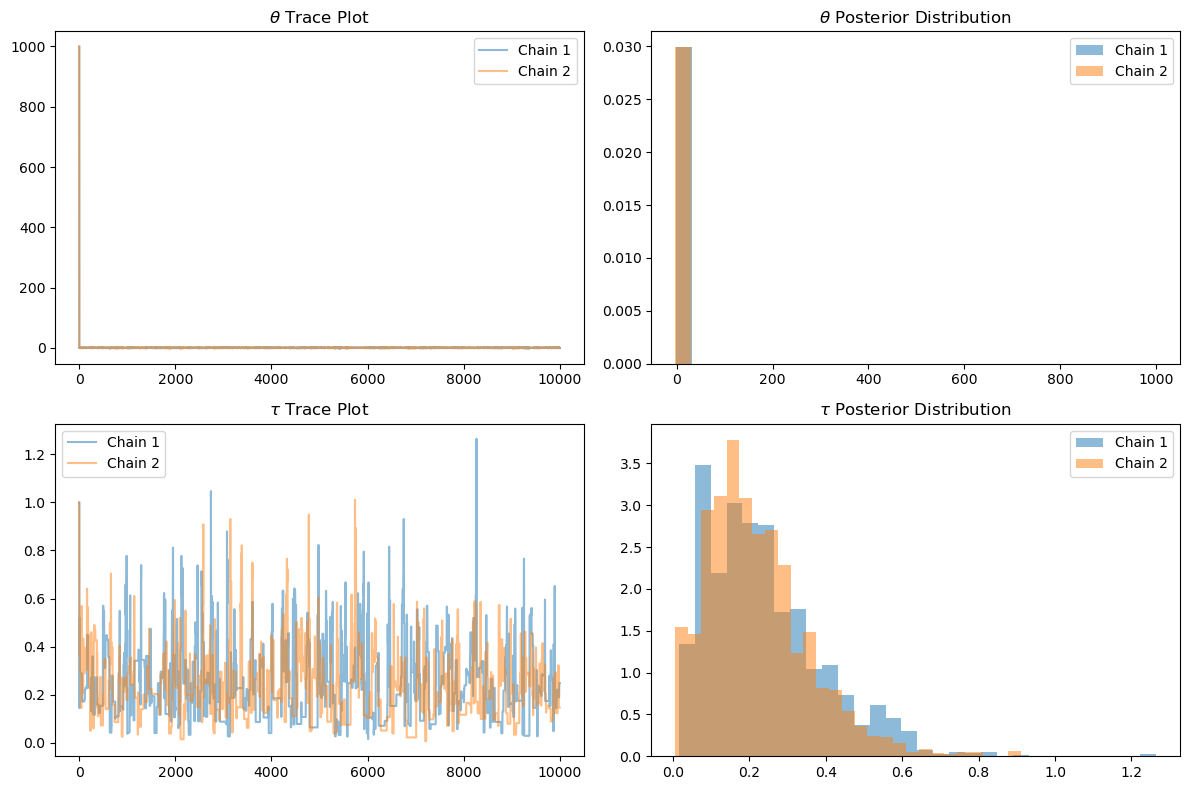

In [6]:
# Q1
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Set parameters
n = 30  # Sample size
m = 0   # True mean
s = 1   # True standard deviation
x = stats.norm(loc=m, scale=s).rvs(size=n)  # Simulated data

# Prior hyperparameters
theta0 = 0    # Prior mean for theta
tau0_sq = 1   # Prior variance for theta
alpha = 2     # Shape parameter for tau
lambda_ = 1   # Rate parameter for tau

# Metropolis within Gibbs parameters
C, G = 2, 10000  # Chains, Gibbs samples
theta, tau = np.zeros((C, G)), np.zeros((C, G))
theta[:, 0] = 1000  # Initialize theta
tau[:, 0] = 1       # Initialize tau

# Independent proposal distribution for tau
proposal_shape, proposal_rate = alpha, lambda_  # Gamma proposal

# Joint density function (up to proportionality)
def log_joint_density(theta, tau):
    log_prior_theta = -0.5 * (theta - theta0) ** 2 / tau0_sq  # Normal prior
    log_prior_tau = (alpha - 1) * np.log(tau) - lambda_ * tau  # Gamma prior
    log_likelihood = -0.5 * tau * np.sum((x - theta) ** 2)  # Gaussian likelihood
    return log_prior_theta + log_prior_tau + log_likelihood

# Metropolis within Gibbs sampling
for c in range(C):
    for g in range(1, G):
        # Gibbs update for theta
        mean_theta = (tau[c, g-1] * np.sum(x) + theta0 / tau0_sq) / (tau[c, g-1] * n + 1 / tau0_sq)
        var_theta = 1 / (tau[c, g-1] * n + 1 / tau0_sq)
        theta[c, g] = stats.norm.rvs(loc=mean_theta, scale=np.sqrt(var_theta))
        
        # Metropolis-Hastings update for tau
        tau_proposed = stats.gamma.rvs(a=proposal_shape, scale=1/proposal_rate)
        log_acceptance_ratio = log_joint_density(theta[c, g], tau_proposed) - log_joint_density(theta[c, g], tau[c, g-1])
        
        if np.log(stats.uniform.rvs()) < log_acceptance_ratio:
            tau[c, g] = tau_proposed  # Accept proposal
        else:
            tau[c, g] = tau[c, g-1]  # Reject proposal and keep previous tau

# Plot results
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for c in range(C):
    axes[0, 0].plot(theta[c, :], alpha=0.5, label=f'Chain {c+1}')
    axes[1, 0].plot(tau[c, :], alpha=0.5, label=f'Chain {c+1}')
    axes[0, 1].hist(theta[c, :], bins=30, density=True, alpha=0.5, label=f'Chain {c+1}')
    axes[1, 1].hist(tau[c, :], bins=30, density=True, alpha=0.5, label=f'Chain {c+1}')

axes[0, 0].set_title("$\\theta$ Trace Plot")
axes[1, 0].set_title("$\\tau$ Trace Plot")
axes[0, 1].set_title("$\\theta$ Posterior Distribution")
axes[1, 1].set_title("$\\tau$ Posterior Distribution")
for ax in axes.flatten(): ax.legend()
plt.tight_layout()
plt.show()

### Q2

Adjust your **Metropolis within Gibbs** sampler as follows.

- Use the following **dependent** proposal for $\tau$

```Python
stats.truncnorm(a=-tau_t_minus_1/s, b=np.inf,
                loc=tau_t_minus_1, scale=s)
```

- Use a prior for $\theta$ that is not a normal distribution 


*Provide a demonstration showing the Bayesian inference provided by this sampler. Then discuss the necessity (or lackthereof) of analytically determining the full conditional distributions when performing Gibbs sampling.*


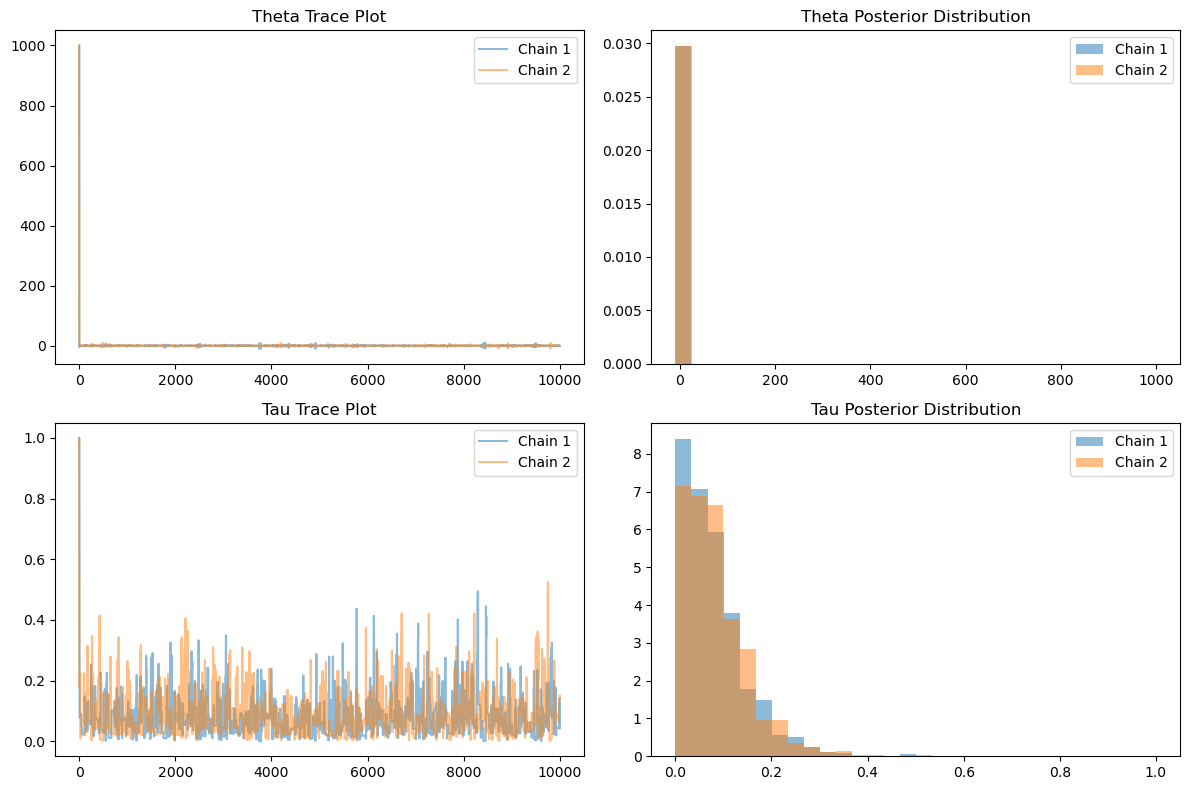

In [8]:
# Q2
# Set parameters
n = 30  # Sample size
m = 0   # True mean
s = 1   # True standard deviation
x = stats.norm(loc=m, scale=s).rvs(size=n)  # Simulated data

# Prior hyperparameters
theta0 = 0    # Prior mean for theta
tau0_sq = 1   # Prior variance for theta
alpha = 2     # Shape parameter for tau
lambda_ = 1   # Rate parameter for tau

# Metropolis within Gibbs parameters
C, G = 2, 10000  # Chains, Gibbs samples
theta, tau = np.zeros((C, G)), np.zeros((C, G))
theta[:, 0] = 1000  # Initialize theta
tau[:, 0] = 1       # Initialize tau

# Non-Normal prior for theta (e.g., Uniform prior)
def log_prior_theta(theta):
    return np.where((-10 <= theta) & (theta <= 10), 0, -np.inf)  # Uniform prior on [-10,10]

# Joint density function (up to proportionality)
def log_joint_density(theta, tau):
    log_prior_tau = (alpha - 1) * np.log(tau) - lambda_ * tau  # Gamma prior
    log_likelihood = -0.5 * tau * np.sum((x - theta) ** 2)  # Gaussian likelihood
    return log_prior_theta(theta) + log_prior_tau + log_likelihood

# Metropolis within Gibbs sampling
for c in range(C):
    for g in range(1, G):
        # Metropolis-Hastings update for theta with non-normal prior
        theta_proposed = stats.uniform.rvs(-10, 20)  # Sample from Uniform prior
        log_acceptance_ratio = log_joint_density(theta_proposed, tau[c, g-1]) - log_joint_density(theta[c, g-1], tau[c, g-1])
        
        if np.log(stats.uniform.rvs()) < log_acceptance_ratio:
            theta[c, g] = theta_proposed  # Accept proposal
        else:
            theta[c, g] = theta[c, g-1]  # Reject proposal
        
        # Metropolis-Hastings update for tau with dependent proposal
        tau_t_minus_1 = tau[c, g-1]
        proposal_dist = stats.truncnorm(a=-tau_t_minus_1/s, b=np.inf, loc=tau_t_minus_1, scale=s)
        tau_proposed = proposal_dist.rvs()
        log_acceptance_ratio = log_joint_density(theta[c, g], tau_proposed) - log_joint_density(theta[c, g], tau[c, g-1])
        
        if np.log(stats.uniform.rvs()) < log_acceptance_ratio:
            tau[c, g] = tau_proposed  # Accept proposal
        else:
            tau[c, g] = tau[c, g-1]  # Reject proposal

# Plot results
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for c in range(C):
    axes[0, 0].plot(theta[c, :], alpha=0.5, label=f'Chain {c+1}')
    axes[1, 0].plot(tau[c, :], alpha=0.5, label=f'Chain {c+1}')
    axes[0, 1].hist(theta[c, :], bins=30, density=True, alpha=0.5, label=f'Chain {c+1}')
    axes[1, 1].hist(tau[c, :], bins=30, density=True, alpha=0.5, label=f'Chain {c+1}')

axes[0, 0].set_title("$\\theta$ Trace Plot")
axes[1, 0].set_title("$\\tau$ Trace Plot")
axes[0, 1].set_title("$\\theta$ Posterior Distribution")
axes[1, 1].set_title("$\\tau$ Posterior Distribution")
for ax in axes.flatten(): ax.legend()
plt.tight_layout()
plt.show()

### Q2 Discussion:
In standard Gibbs sampling, full conditionals are required, but deriving them can sometimes be difficult or impossible. When available, they ensure computational efficiency and high acceptance rates. When full conditionals are intractable, Metropolis-Hastings within Gibbs offers flexibility by using tunable proposal distributions, enabling sampling from the joint posterior even with complex priors.


### Q3 

For **Metropolis Hastings** targetting (**stationary distribution**) $p$ based on proposal distribuiton $q$ given below

$\begin{align}
q(\tilde x^{(t)} | x^{(t-1)}) &={} \left(\frac{1}{2}\right)^{1-{\tilde x^{(t)}}}\left(\frac{1}{2}\right)^{\tilde x^{(t)}} \quad \color{gray}{\textrm{ ... does } \quad \frac{q(x^{(t-1)}|\tilde x^{(t)})}{q(\tilde x^{(t)}|x^{(t-1)})} \quad  \textrm{ cancel?}}\\
\textrm{and} \quad p(x^{(t)}) &={} \left(\frac{1}{3}\right)^{1-{x^{(t)}}}\left(\frac{2}{3}\right)^{x^{(t)}}\\
\end{align}$

<u>show that</u> the **transition kernel** $K$ of transition probabilities is defined the **Metropolis Hastings** algorithm is

$K = \left[\begin{array}{cc}\Pr(x^{(t)}=0 \rightarrow x^{(t+1)}=0) & \Pr(x^{(t)}=1 \rightarrow x^{(t+1)}=0)\\\Pr(x^{(t)}=0 \rightarrow x^{(t+1)}=1)& \Pr(x^{(t)}=1 \rightarrow x^{(t+1)}=1)\end{array}\right] = \left[\begin{array}{cl} 0.5 & 0.25 \\ 0.5 & 0.75 \end{array}\right]$

> For example 
>
> $\begin{align}
\Pr(s_1 \rightarrow s_1) &={}
q(\tilde x^{(t)}=1 | x^{(t-1)}=1) + q(\tilde x^{(t)}=0 | x^{(t-1)}=1) \left(1- \frac{p(\tilde x^{(t)}=0)}{p(x^{(t-1)}=1)}\right)\\
&={} 1/2 + (1/2)(1-(1/3)/(2/3)) = 0.75
\end{align}$


### Q3 

**Proposal Distribution:**

$$
q\left(\tilde{x}^{(t)} \mid x^{(t-1)}\right)=\left(\frac{1}{2}\right)^{1-\tilde{x}^{(t)}}\left(\frac{1}{2}\right)^{\tilde{x}^{(t)}}
$$

This implies the proposal is symmetric:

$$
q(0 \mid 1)=q(1 \mid 0)=\frac{1}{2}, \quad q(0 \mid 0)=q(1 \mid 1)=\frac{1}{2}
$$

**Target (Stationary) Distribution:**

$$
p\left(x^{(t)}\right)=\left(\frac{1}{3}\right)^{1-x^{(t)}}\left(\frac{2}{3}\right)^{x^{(t)}}
$$

which implies:

$$
p(0)=\frac{1}{3}, \quad p(1)=\frac{2}{3}
$$

**Acceptance Probability:**

In the Metropolis-Hastings algorithm, the acceptance probability is:

$$
\alpha\left(x^{(t-1)} \rightarrow \tilde{x}^{(t)}\right)=\min \left(1, \frac{p\left(\tilde{x}^{(t)}\right)}{p\left(x^{(t-1)}\right)} \frac{q\left(x^{(t-1)} \mid \tilde{x}^{(t)}\right)}{q\left(\tilde{x}^{(t)} \mid x^{(t-1)}\right)}\right)
$$


Since the proposal distribution is symmetric, the ratio of proposals cancels:

$$
\frac{q\left(x^{(t-1)} \mid \tilde{x}^{(t)}\right)}{q\left(\tilde{x}^{(t)} \mid x^{(t-1)}\right)}=1
$$


So the acceptance probability simplifies to:

$$
\alpha\left(x^{(t-1)} \rightarrow \tilde{x}^{(t)}\right)=\min \left(1, \frac{p\left(\tilde{x}^{(t)}\right)}{p\left(x^{(t-1)}\right)}\right)
$$

**Substituting Values:**

Given $p(0)=\frac{1}{3}$ and $p(1)=\frac{2}{3}$, we compute:

$$
\begin{aligned}
& \alpha(1 \rightarrow 0)=\min \left(1, \frac{p(0)}{p(1)}\right)=\min \left(1, \frac{\frac{1}{3}}{\frac{2}{3}}\right)=\frac{1}{2} \\
& \alpha(0 \rightarrow 1)=\min \left(1, \frac{p(1)}{p(0)}\right)=\min \left(1, \frac{\frac{2}{3}}{\frac{1}{3}}\right)=1
\end{aligned}
$$

**Transition Matrix:**

We now compute the elements of the transition matrix

- Probability of Staying at K(0 to 0):

$$
\begin{aligned}
K(0 \rightarrow 0) & =q(1 \mid 0) \cdot(1-\alpha(0 \rightarrow 1))+q(0 \mid 0) \\
& =\frac{1}{2} \cdot(1-1)+\frac{1}{2}=0.5 
\end{aligned}
$$

- Probability of Moving from K(0 to 1):

$$
K(0 \rightarrow 1)=q(1 \mid 0) \cdot \alpha(0 \rightarrow 1)=\frac{1}{2} \cdot 1=0.5 
$$

- Probability of Moving from K(1 to 0):

$$
K(1 \rightarrow 0)=q(0 \mid 1) \cdot \alpha(1 \rightarrow 0)=\frac{1}{2} \cdot \frac{1}{2}=0.25 
$$

- Probability of Staying at K(1 to 1):

$$
\begin{aligned}
K(1 \rightarrow 1) & =q(0 \mid 1) \cdot(1-\alpha(1 \rightarrow 0))+q(1 \mid 1) \\
& =\frac{1}{2} \cdot\left(1-\frac{1}{2}\right)+\frac{1}{2}=0.75 
\end{aligned}
$$

Thus, the transition kernel K is:

$$
K=\left[\begin{array}{ll}
0.5 & 0.25 \\
0.5 & 0.75
\end{array}\right]
$$

**Stationary Distribution:**

The stationary distribution $\pi=\left[\pi_0, \pi_1\right]$ satisfies: $ \pi K=\pi $


Solving the equations:

$$
\begin{aligned} 
& \pi_0=0.5 \pi_0+0.25 \pi_1, \ & \pi_1=0.5 \pi_0+0.75 \pi_1
\end{aligned}
$$


With $\pi_0+\pi_1=1$, we find:

$$
\pi_0=\frac{1}{3}, \quad \pi_1=\frac{2}{3}
$$

Thus, the stationary distribution matches the target distribution as expected.